# Resumo

O artigo propõe um sistema ALPR com foco em cenários de captura irrestrita, onde o LP pode ser consideravelmente 
distorcida devido a visualizações oblíquas.
A principal contribuição é a introdução de uma nova Rede Neural Convulocional(CNN) capaz de detectar e retificar 
múltiplas placas distorcidas em um única imagem, que é alimentada por um sistema de reconhecimento ótico de caracteres.

Contribuição adicional: apresentam anotações manuais para um conjunto desafiador de imagens LP de diferentes regiões e
condições de aquisição.

ALPR = Automatic License Plate Recognition = reconhecimento automático de placas de veículos

Uso de imagens sinteticamente distorcidas permitindo um treinamento usando menos de 200 imagens rotuladas manualmente.

### Abordagem para as LP brasileiros

treinar novamente a sua rede de OCR usando um novo conjunto de treinamento composto por uma mistura de dados reais e gerados artificialmente usando tipos de fontes semelhantes as da região-alvo.

Como resultado, a rede retreinada tornou-se muito mais robusta para detecção e classificação de personagens reais no cenário original brasileiro, mas também para LPs europeus e taiwaneses, alcançando altíssima precisão e taxas de recall. 

Todos os dados anotados utilizados para este trabalho estão disponíveis publicamente
e as imagens de referência podem ser obtidas baixando o Cars Dataset [16],
o banco de dados SSIG [6] e o conjunto de dados AOLP [10].

### Revisar abordagens relacionadas ao ALPR

In [ ]:
ALPR é a tarefa de localizar e reconhecer placas em imagens

Comumente dividida em 4 subtarefas que formam um pipeline sequencial:

1 - detecção de veículos
2 - detecção de placas
3 - segmentação de caracteres
4 - reconhecimentos de caracteres

A combinação das duas últimas = OCR

Obs: YOLO lutam para detectar objetos de pequeno porte, assim ainda mais são necessárias avaliações sobre cenários onde o carro está longe da câmera.

## O método proposto

Dada uma imagem de entrada, o primeiro módulo detecta veículos na cena. Dentro de cada região de detecção a proposta
Warped Planar Object Detection Network (WPOD-NET) procura LP e regride uma transformação afim por detecção, permitindo uma retificação da área LP em um retângulo semelhante a uma vista frontal. Estes positivos e retificados, as detecções são alimentadas em uma rede OCR para reconhecimento final de caracteres.

### Detecção de veículos

imagens de entrada maiores permitem a detecção de objetos menores, mas aumentam o custo computacional. Em vistas aproximadamente frontais/traseiras, a relação entre o tamanho da LP e a caixa delimitadora (BB) do veículo é alta.

No entanto, essa relação tende a ser muito menor para vistas oblíquas/laterais, pois a BB do veículo tende a ser maior e mais alongada

Portanto, vistas oblíquas devem ser redimensionadas para uma dimensão maior do que as frontais para manter a região da LP ainda reconhecível. Embora métodos de estimação de pose 3D, como o mencionado, possam ser usados para determinar a escala de redimensionamento, este trabalho apresenta um procedimento simples e rápido baseado na razão de aspecto da BB do veículo. Quando está próximo de um, uma dimensão menor pode ser usada, e deve ser aumentada à medida que a razão de aspecto fica maior.  

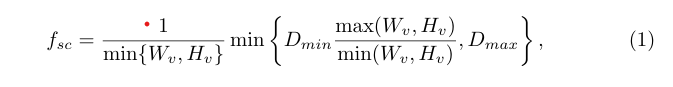

onde Wv e Hv são a largura e a altura da caixa delimitadora do veículo, respectivamente. Note que Dmin ≤ fscmin(Wv,Hv) ≤ Dmax, de modo que Dmin and Dmax delimitam o intervalo para a menor dimensão da BB redimensionada. Com base em experimentos e tentando manter um bom compromisso entre precisão e tempos de execução,selecionamos Dmin = 288 and Dmax = 608

### Detecção de placas e desdobramentos

Como placas são retangulares, o artigo propoẽ uma nova rede chamada rede de detecção de objetos planos distorcidos. A rede aprendre a detectar LP em uma variedade de distorções diferentes e regredir os coeficientes de uma transformação afim que 'desdobra' a LP distorcida em uma forma retangular que se assemelha a uma visão frontal.

a rede foi desenvolvida utilizando YOLO, SSD e redes de tranformação espacial(STN). O YOLO e o SSD realização detecção e reconhecimento rápido de múltiplos objetos de uma vez, mas não levam em consideração transformações espaciais, gerando apenas caixas delimitadoras retangulares para cada detecção. Por outro lado, a STN pode ser usada para detectar regiões não retangulares, no entanto, não consegue lidar com múltiplas transformações ao mesmo tempo, realizando apenas uma transformação espacial sobre todo o input.

IMPORTANTE!!!

Inicialmente, a rede(WPOD-NET) é alimentada pela saída redimensionada do módulo de detecção de veículos. O avanço resulta em um mapa de características de 8 canais que codifica as probabilidades de objeto/não objeto e os parâmetros de transformações afim. 


Para extrair a LP distorcida, vamos primeiro considerar um quadrado imaginário de tamanho fixo ao redor do centro de uma célula(m.n). Se a probabilidade de objeto desta célula estiver acima de um determinado limiar da detecção, parte dos parâmetros regredidos é usada para construir uma matriz afim que transforma o quadrado fictício em uma região de LP. Dessa forma, podemos desdobrar a LP em um objeto alinhado horizontal e verticalmente. 

### Arquitetura da rede

A arquitetura proposta possui um total de 21 camadas convolucionais, onde 14 estão dentro de blocos residuais. O tamanho de todos os filtros convolucionais é fixo em 3 × 3. Ativações ReLU são utilizadas em toda a rede, exceto no bloco de detecção. Existem 4 camadas de max pooling de tamanho 2 × 2 e passo 2 que reduzem a dimensionalidade de entrada por um fator de 16. Finalmente, o bloco de detecção possui duas camadas convolucionais paralelas: (i) uma para inferir a probabilidade, ativada por uma função softmax, e (ii) outra para regredir os parâmetros afins, sem ativação (ou, de forma equivalente, utilizando a identidade F(x) = x como função de ativação).

![Captura de tela de 2024-05-09 14-39-45.png](<attachment:Captura de tela de 2024-05-09 14-39-45.png>)
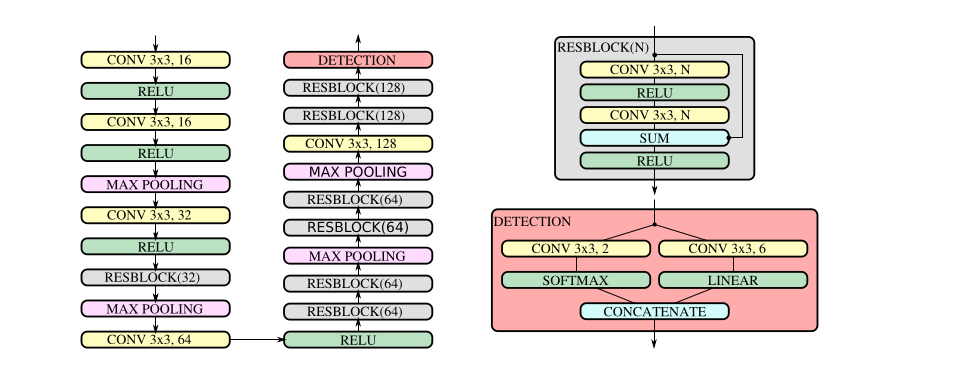

### Função de Perda

!!! Importante

A função de perda descrita no texto é usada em um sistema de reconhecimento de placas veiculares para treinar uma rede neural convolucional. Ela mede a diferença entre as localizações previstas pela rede e as localizações reais das placas nas imagens.

Aqui está uma explicação dos elementos principais da função de perda:

pi (coordenadas da placa anotada): Representa os quatro cantos de uma placa anotada na imagem, iniciando no canto superior esquerdo e seguindo no sentido horário.
qi (vértices da praça unitária): Define os quatro cantos de um quadrado unitário padrão usado como referência.
Saída da rede: A rede gera um mapa de características que indica a probabilidade de haver uma placa em cada ponto da imagem e os parâmetros para refinar a localização prevista.
Transformação afim (Tmn): É usada para ajustar a praça unitária padrão de acordo com a previsão da rede para cada ponto do mapa de características.
Função de normalização (Amn): Redimensiona e recentraliza as coordenadas anotadas da placa para corresponder à resolução da saída da rede.
Iobj (indicador de objeto): É uma função que retorna 1 se houver uma placa em um determinado ponto do mapa de características e 0 caso contrário.
Função de perda de probabilidade (fprobs): Mede o erro entre as probabilidades previstas pela rede (v1 e v2) e a presença real de uma placa (Iobj).
Função de perda afim (faffine): Mede a diferença entre a localização ajustada da praça unitária (Tmn(qi)) e a localização real da placa normalizada (Amn(pi)).
A função de perda final é uma combinação ponderada da função de perda de probabilidade e da função de perda afim. Ela é calculada para todos os pontos do mapa de características onde há uma possível placa (indicado por Iobj). Ao minimizar essa função de perda durante o treinamento, a rede aprende a prever a localização e a probabilidade de placas veiculares nas imagens com mais precisão.

Alguns pontos adicionais:

A função utiliza max(v3, 0) e max(v6, 0) para garantir que a diagonal da transformação afim seja positiva, evitando rotações excessivas ou espelhamento indesejado.
O constante α na função de normalização é definido como a média entre as dimensões máxima e mínima das placas nos dados de treinamento aumentados, dividido pelo stride da rede.
Espero que essa explicação em português ajude a esclarecer a função de perda utilizada no sistema de reconhecimento de placas veiculares.

Para realizar a transformação afim em uma imagem de placa veicular, você precisa dos seguintes parâmetros:

1. Parâmetros da Transformação Afim:

Escala (v3 e v8): Esses parâmetros controlam o tamanho da placa na imagem transformada. v3 representa a escala horizontal, enquanto v8 representa a escala vertical.
Inclinação (v4 e v5): Esses parâmetros controlam a inclinação da placa na imagem transformada. v4 representa a inclinação horizontal, enquanto v5 representa a inclinação vertical.
Translação (v6 e v7): Esses parâmetros controlam a posição da placa na imagem transformada. v6 representa a translação horizontal, enquanto v7 representa a translação vertical.
2. Coordenadas da Placa Anotada:

Coordenadas dos Cantos (pi): As coordenadas dos quatro cantos da placa na imagem original. Isso é necessário para calcular a transformação afim que mapeia a placa original para a placa transformada.
3. Pontos de Referência da Praça Unitária:

Coordenadas dos Vértices (qi): As coordenadas dos quatro cantos de um quadrado unitário padrão. Isso é usado como referência para a placa transformada.
4. Parâmetros Adicionais:

Normalização (Amn): Essa função é opcional e pode ser usada para redimensionar e recentralizar as coordenadas da placa anotada para corresponder à resolução da saída da rede.
Coeficiente de Escala (α): Esse parâmetro define o tamanho da praça unitária na imagem transformada. É geralmente definido como a média entre as dimensões máxima e mínima das placas nos dados de treinamento, dividido pelo stride da rede.
Cálculo da Transformação Afim:

Com base nos parâmetros acima, a transformação afim (Tmn) para um ponto arbitrário (q) na imagem transformada pode ser calculada da seguinte forma:

Tmn(q) = [ max(v3, 0)  v4  v7 ]
         [ v5  max(v6, 0)  v8 ]
Essa matriz de transformação afim mapeia o ponto (q) na imagem original para o ponto correspondente na imagem transformada.